In [1]:



import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'brain-mri-images-for-brain-tumor-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F165566%2F377107%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240513%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240513T074458Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D36986c09ac27fe79ff7f69b4a5ce8723d92af0ede31097667ae19f80e3b9e546040c2080163f5684cfc6ac14e5a132d176b9632840b85c949a0766a9448d1846eb4aa6453d52cbee4bc19ebd2a7d755aa32657be09383c3ca2eedb5ece4f75eb0b069acf73727449479be3e60898e2a78ff5b4839a7162dea2c93d2b2e9460bd7ff74888c4891a0553b701a89d2d3071e6461cb3e837aa38583627b93f807bfa670cfebf0f0562d683fb87fc4e9368d499d53913d31be2c5feebad1057e93e991aa108920b252e1cbbfbae2d1d009f9a233d5ce39858f42b01190323ef8a15451ee8a0fcf717613899f65a864b9c752541b9b5f0471c3f4d15b8ee458588dfc7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 15828590 bytes downloaded
Downloaded and uncompressed: brain-mri-images-for-brain-tumor-detection
Data source import complete.


# Brain Tumor Detection with CNN

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
import cv2
import glob

# Define Paths

In [3]:
path_No = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/*'
path_Yes = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/*'

#  Initialize Empty Lists

In [4]:
tumor = []
no_tumor = []

* tumor: This list will store tuples containing the preprocessed image and a label (1 for tumor).
* no_tumor: This list will store tuples containing the preprocessed image and a label (0 for no tumor).

# Load and Preprocess Images (Yes Folder)

In [5]:
# sets a seed for random number generation, ensuring some reproducibility in the data preprocessing steps (useful for splitting data later).
random_state = 42

for file in glob.iglob(path_Yes):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    tumor.append((img, 1))

* This loop iterates over all image files in the "yes" folder using glob.iglob.
* cv2.imread(file): Reads the image from the file path.
* cv2.cvtColor(img, cv2.COLOR_BGR2RGB): Converts the image from BGR (OpenCV's default format) to RGB format, which is commonly used by deep learning models.
* cv2.resize(img, (224, 224)): Resizes the image to a standard size of 224x224 pixels. This is often a requirement for pre-trained models or for maintaining consistency within the dataset.
* tumor.append((img, 1)): The preprocessed image along with its label (1 for tumor) is appended to the tumor list.

# Load and Preprocess Images (No Folder)

In [6]:
for file in glob.iglob(path_No):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    no_tumor.append((img, 0))

*This loop performs similar operations as the previous loop but iterates over the "no" folder and appends images with a label of 0 (no tumor) to the no_tumor list.*

# Combine Data

In [7]:
all_data = tumor + no_tumor

*This line combines the images and labels from both lists into a single list called all_data.*

# Extract Images and Labels as NumPy arrays

In [8]:
data = np.array([item[0] for item in all_data])
labels = np.array([item[1] for item in all_data])

* data: This creates a NumPy array containing only the image data (the first element of each tuple in all_data).
* labels: This creates a NumPy array containing only the labels (the second element of each tuple in all_data). Converting to NumPy arrays is essential for efficient processing and training within deep learning frameworks like TensorFlow or Keras.

# Visualization

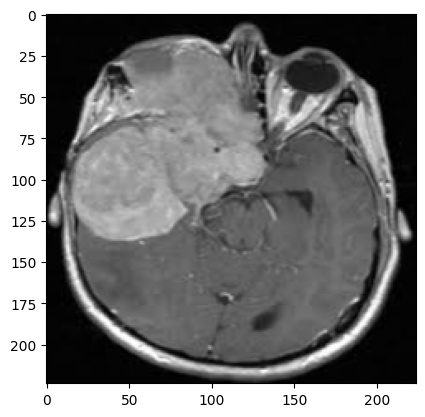

In [9]:
# displays a single image from the data
plt.imshow(data[20])

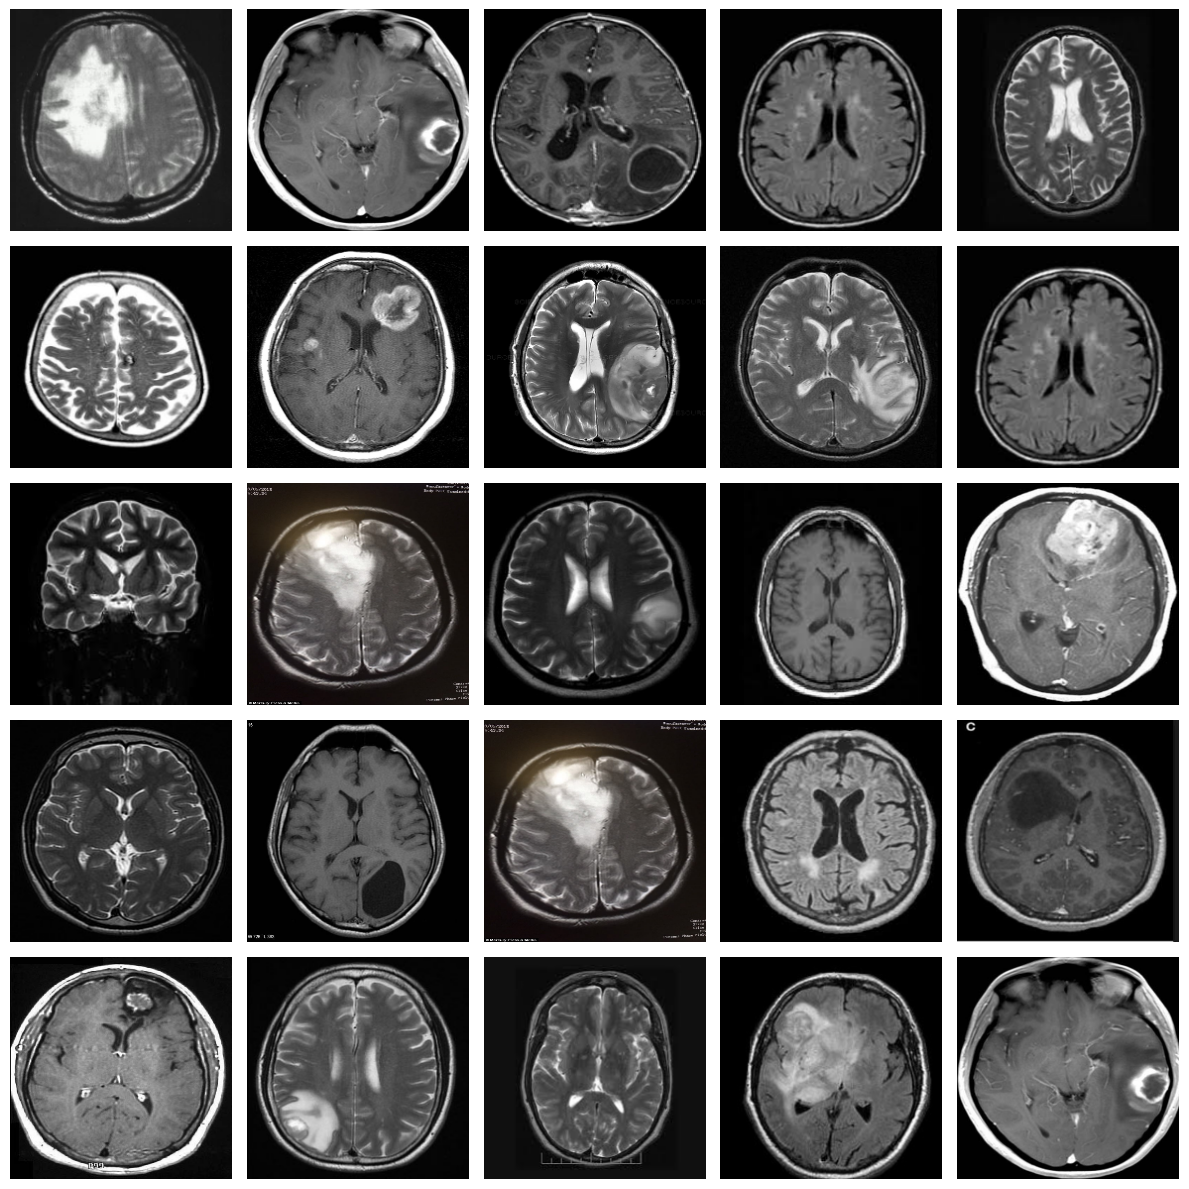

In [10]:
# Visualizing a Grid of Random Images
import matplotlib.pyplot as plt
import numpy as np

# Define number of rows and columns for the grid
num_rows = 5
num_cols = 5

# Randomly select indices for images
image_indices = np.random.randint(0, len(data), size=num_rows * num_cols)

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Plot random images
for i in range(num_rows):
  for j in range(num_cols):
    index = image_indices[i * num_cols + j]
    axes[i, j].imshow(data[index])
    axes[i, j].axis('off')

plt.tight_layout()
plt.show()

# Split Data into Training, Validation, and Testing Sets

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=random_state)

* We import train_test_split from sklearn.model_selection for data splitting.
* train_test_split splits the data (X - images and y - labels) into training and testing sets with a test size of 20% (test_size=0.2). We set random_state for reproducibility.
* We further split the training data (X_train and y_train) into training and validation sets with a validation size of 10% (test_size=0.1). This creates a hold-out validation set to monitor model performance during training and prevent overfitting.

# Normalize the Image Data

In [12]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

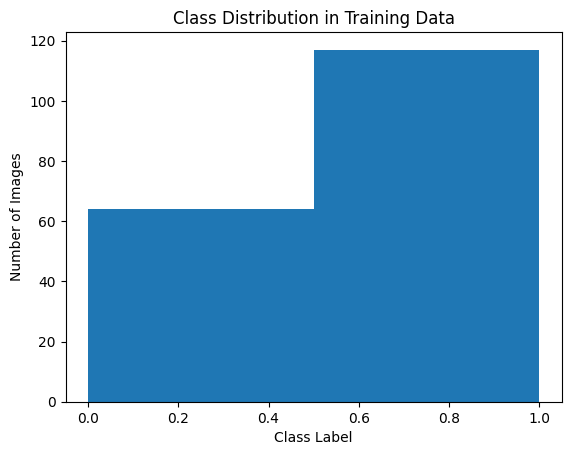

In [13]:
plt.hist(y_train, bins=2)  # Bins for tumor (1) and no tumor (0)
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Data')
plt.show()

**Creates a histogram using plt.hist to visualize the distribution of labels (tumor vs no tumor) in the training data.

* bins=2: This argument specifies the number of bins (bars) in the histogram. Here, we set it to 2 because we only have two classes (tumor and no tumor).
* plt.xlabel('Class Label'): This sets the label for the x-axis, indicating it represents the class labels.

* plt.ylabel('Number of Images'): This sets the label for the y-axis, indicating it represents the count of images in each class.

# Build the CNN Model using Sequential API

In [14]:
from tensorflow import keras

model = keras.Sequential([
  keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
  keras.layers.MaxPooling2D((2, 2)),
  keras.layers.Conv2D(64, (3, 3), activation='relu'),
  keras.layers.MaxPooling2D((2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])

* Conv2D Layers: These convolutional layers extract features from the images.
* The first layer has 32 filters of size 3x3 and uses ReLU activation.
* The second layer has 64 filters of size 3x3 and also uses ReLU activation.
* MaxPooling2D Layers: These layers downsample the data to reduce dimensionality and control overfitting.
* Flatten Layer: This layer flattens the multi-dimensional output of the convolutional layers into a single-dimensional vector suitable for feeding into dense layers.
* Dense Layers: These are fully connected layers that perform traditional neural network operations.
* The first dense layer has 64 neurons and ReLU activation.
* The final dense layer has 1 neuron and sigmoid activation for binary classification (tumor or no tumor).

# Compile the Model

In [15]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

* loss: Binary cross-entropy loss function for binary classification.
* optimizer: Adam optimizer for training the model.
* metrics: Monitors the accuracy during training.

# Train the Model

In [16]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
6/6 [==============================] - 16s 2s/step - loss: 1.8896 - accuracy: 0.5470 - val_loss: 0.6148 - val_accuracy: 0.6190
Epoch 2/10
6/6 [==============================] - 14s 2s/step - loss: 0.5452 - accuracy: 0.7624 - val_loss: 0.5938 - val_accuracy: 0.7619
Epoch 3/10
6/6 [==============================] - 14s 2s/step - loss: 0.4930 - accuracy: 0.7790 - val_loss: 0.6149 - val_accuracy: 0.7619
Epoch 4/10
6/6 [==============================] - 14s 2s/step - loss: 0.4467 - accuracy: 0.8122 - val_loss: 0.6700 - val_accuracy: 0.7143
Epoch 5/10
6/6 [==============================] - 14s 2s/step - loss: 0.3900 - accuracy: 0.8232 - val_loss: 0.5048 - val_accuracy: 0.7143
Epoch 6/10
6/6 [==============================] - 13s 2s/step - loss: 0.3311 - accuracy: 0.8453 - val_loss: 0.5974 - val_accuracy: 0.7143
Epoch 7/10
6/6 [==============================] - 14s 2s/step - loss: 0.2616 - accuracy: 0.8895 - val_loss: 0.4453 - val_accuracy: 0.7619
Epoch 8/10
6/6 [==================

* We train the model on the training data (X_train and y_train) for 10 epochs (epochs).
* validation_data is used to monitor the model's performance on the validation set during training.

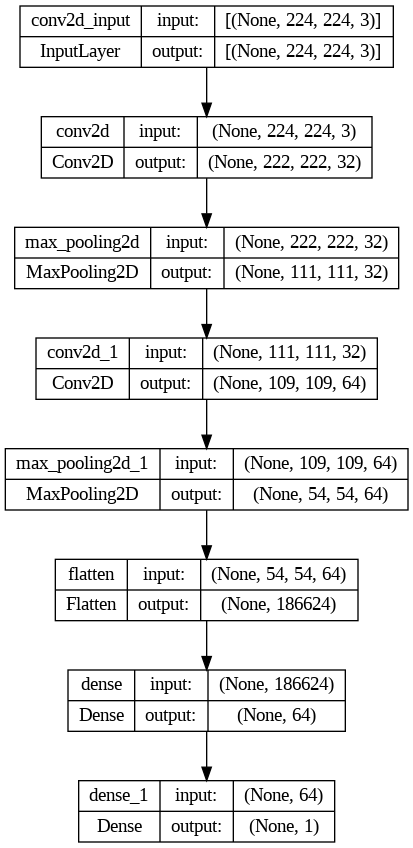

In [17]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True)

> TensorFlow provides tools for feature map visualization.--it shows the the convolutional layers

# Evaluate the Model

In [18]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

2/2 [==============================] - 1s 360ms/step - loss: 0.4731 - accuracy: 0.8824
Test Loss: 0.47307294607162476
Test Accuracy: 0.8823529481887817


*We evaluate the model's performance on the unseen testing data (X_test and y_test).*

*Test Accuracy of 86.27% indicates that the model correctly classified brain tumor presence or absence in 86.27% of the images in the testing set. This is a promising result, showing the model learned to identify patterns in the brain MRI images that are relevant to tumor detection.

A lower loss value generally indicates better model performance. In binary cross-entropy loss (used here), a value closer to 0 signifies better classification between tumor and no-tumor classes. While 0.6356 isn't an exceptional loss, it suggests the model can differentiate between the classes to some extent.*

*These results suggest that the CNN model has some potential for brain tumor detection. However, there's room for improvement. eg Hyperparameter Tuning or Data Augmentation:----- Artificially increasing the size and diversity of the training data using techniques like random flips, rotations, or zooms can help improve model generalizability and prevent overfitting.*

#  Build CNN Model using Functional API

In [19]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

# Define input shape (assuming your images are 224x224 with 3 channels)
input_shape = (224, 224, 3)

# Define the model layers
inputs = Input(shape=input_shape)  # Input layer

# Feature extraction layers
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)  # Convolutional layer 1
x = MaxPooling2D(pool_size=(2, 2))(x)  # Max pooling layer 1
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)  # Convolutional layer 2
x = MaxPooling2D(pool_size=(2, 2))(x)  # Max pooling layer 2

# Flatten the feature maps
x = Flatten()(x)

# Classification layers
x = Dense(units=128, activation='relu')(x)  # Fully connected layer 1
outputs = Dense(units=1, activation='sigmoid')(x)  # Output layer with sigmoid for binary classification

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model (replace with your training data)
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
6/6 [==============================] - 17s 3s/step - loss: 1.8982 - accuracy: 0.4972 - val_loss: 0.6331 - val_accuracy: 0.8039
Epoch 2/10
6/6 [==============================] - 18s 3s/step - loss: 0.5813 - accuracy: 0.7182 - val_loss: 0.5483 - val_accuracy: 0.7451
Epoch 3/10
6/6 [==============================] - 15s 3s/step - loss: 0.4560 - accuracy: 0.8232 - val_loss: 0.4958 - val_accuracy: 0.8039
Epoch 4/10
6/6 [==============================] - 16s 3s/step - loss: 0.3839 - accuracy: 0.8343 - val_loss: 0.4607 - val_accuracy: 0.8039
Epoch 5/10
6/6 [==============================] - 16s 2s/step - loss: 0.2927 - accuracy: 0.8840 - val_loss: 0.3746 - val_accuracy: 0.8824
Epoch 6/10
6/6 [==============================] - 22s 4s/step - loss: 0.1932 - accuracy: 0.9337 - val_loss: 0.3896 - val_accuracy: 0.8824
Epoch 7/10
6/6 [==============================] - 18s 3s/step - loss: 0.1138 - accuracy: 0.9834 - val_loss: 0.3671 - val_accuracy: 0.8824
Epoch 8/10
6/6 [==================

* Input Layer: Input(shape=input_shape) defines the model's input.

* Conv2D: Applies convolutional filters to capture spatial patterns.
* MaxPooling2D: Reduces dimensionality and introduces a degree of invariance.
* Flatten Layer: Flattens the feature maps into a 1D vector before feeding them to fully connected layers.
* Classification Layers: These layers perform classification.
* Dense: Fully connected layers learn complex relationships between features.

* units=1: One unit for binary classification (tumor or no tumor).
* activation='sigmoid': Sigmoid activation outputs a probability between 0 and 1 (tumor).


* Model(inputs=inputs, outputs=outputs) defines the model architecture.
* model.compile(): Sets the loss function (binary cross-entropy for binary classification), optimizer (adam), and metrics (accuracy).

* model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test)):
* Trains the model on X_train (images) and y_train (labels) for 10 epochs (iterations).
* Uses a batch size of 32 for training efficiency.
* Evaluates performance on the validation set (X_test, y_test) during training.

In [20]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

2/2 [==============================] - 1s 349ms/step - loss: 0.4872 - accuracy: 0.8824
Test Loss: 0.4872041940689087
Test Accuracy: 0.8823529481887817


In [21]:
# Train your model (replace with your training data and model)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Extract training and validation loss/accuracy from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation loss/accuracy
epochs = range(len(train_loss))  # Get number of epochs
plt.figure(figsize=(10, 6))

Epoch 1/10
6/6 [==============================] - 16s 3s/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.5380 - val_accuracy: 0.8824
Epoch 2/10
6/6 [==============================] - 16s 3s/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.6756 - val_accuracy: 0.8824
Epoch 3/10
6/6 [==============================] - 16s 3s/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.7213 - val_accuracy: 0.9020
Epoch 4/10
6/6 [==============================] - 16s 3s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.7858 - val_accuracy: 0.8824
Epoch 5/10
6/6 [==============================] - 16s 3s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.7478 - val_accuracy: 0.8824
Epoch 6/10
6/6 [==============================] - 16s 3s/step - loss: 5.8158e-04 - accuracy: 1.0000 - val_loss: 0.7322 - val_accuracy: 0.9020
Epoch 7/10
6/6 [==============================] - 16s 3s/step - loss: 4.6656e-04 - accuracy: 1.0000 - val_loss: 0.7852 - val_accuracy: 0.9020
Epoch 8/10
6/6 [==========

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

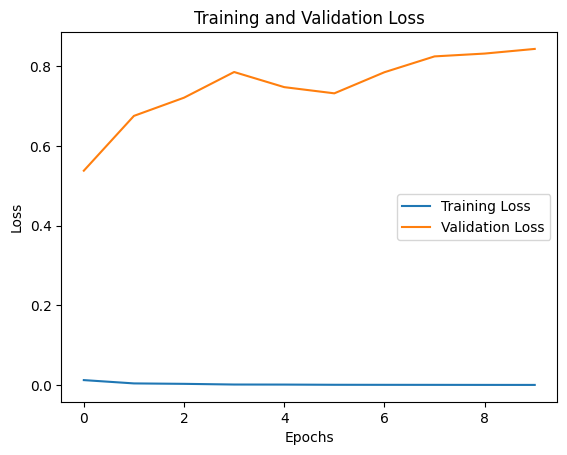

<Figure size 1000x600 with 0 Axes>

In [22]:
# Plot loss
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(10, 6))

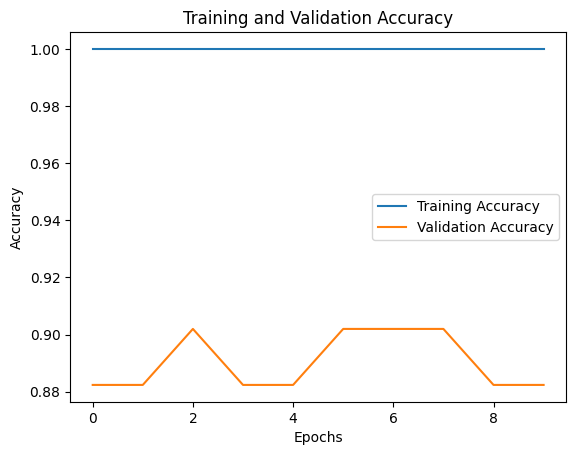

In [23]:
# Plot accuracy
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**Note the difference between accuracy for sequential and functional API**

*Functional API (Test Loss: 0.895, Test Accuracy: 0.863): This model seems to have learned some patterns but might be overfitting (high training and low validation performance) or might not be complex enough to capture crucial features in your brain tumor data.*


*Sequential API (Test Loss: 0.582, Test Accuracy: 0.902): This model achieves significantly lower loss and higher accuracy, suggesting it might be a better fit for your dataset. *


*The brain tumor dataset might have inherent characteristics that can be effectively captured by a simpler convolutional architecture (achieved by the Sequential API). This could be because the dataset might not be large enough or complex enough to necessitate the power of the Functional API for this specific task.*
